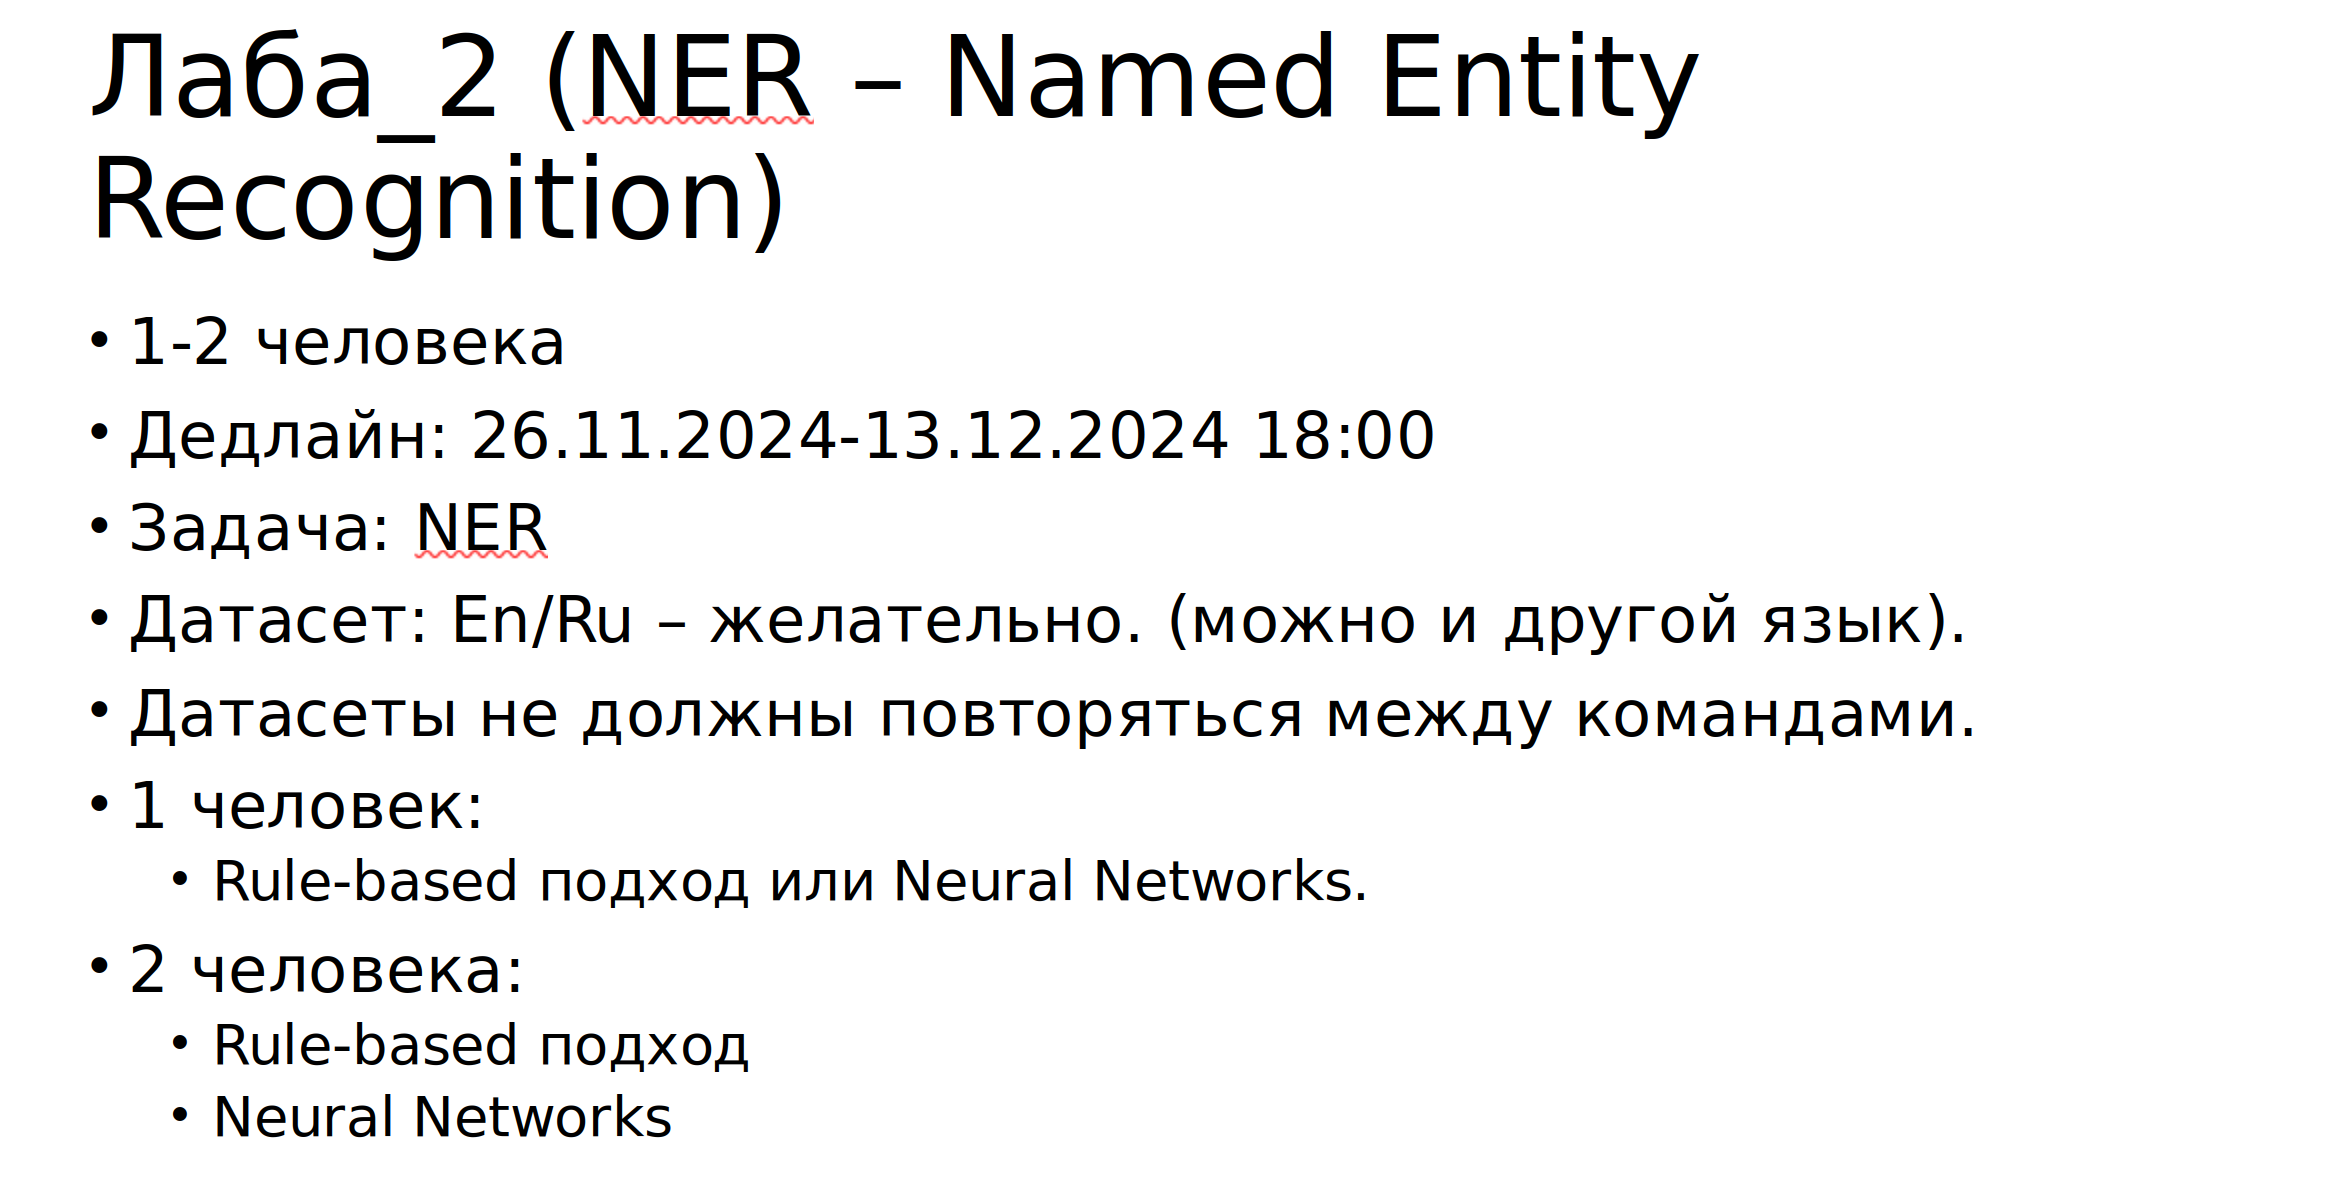

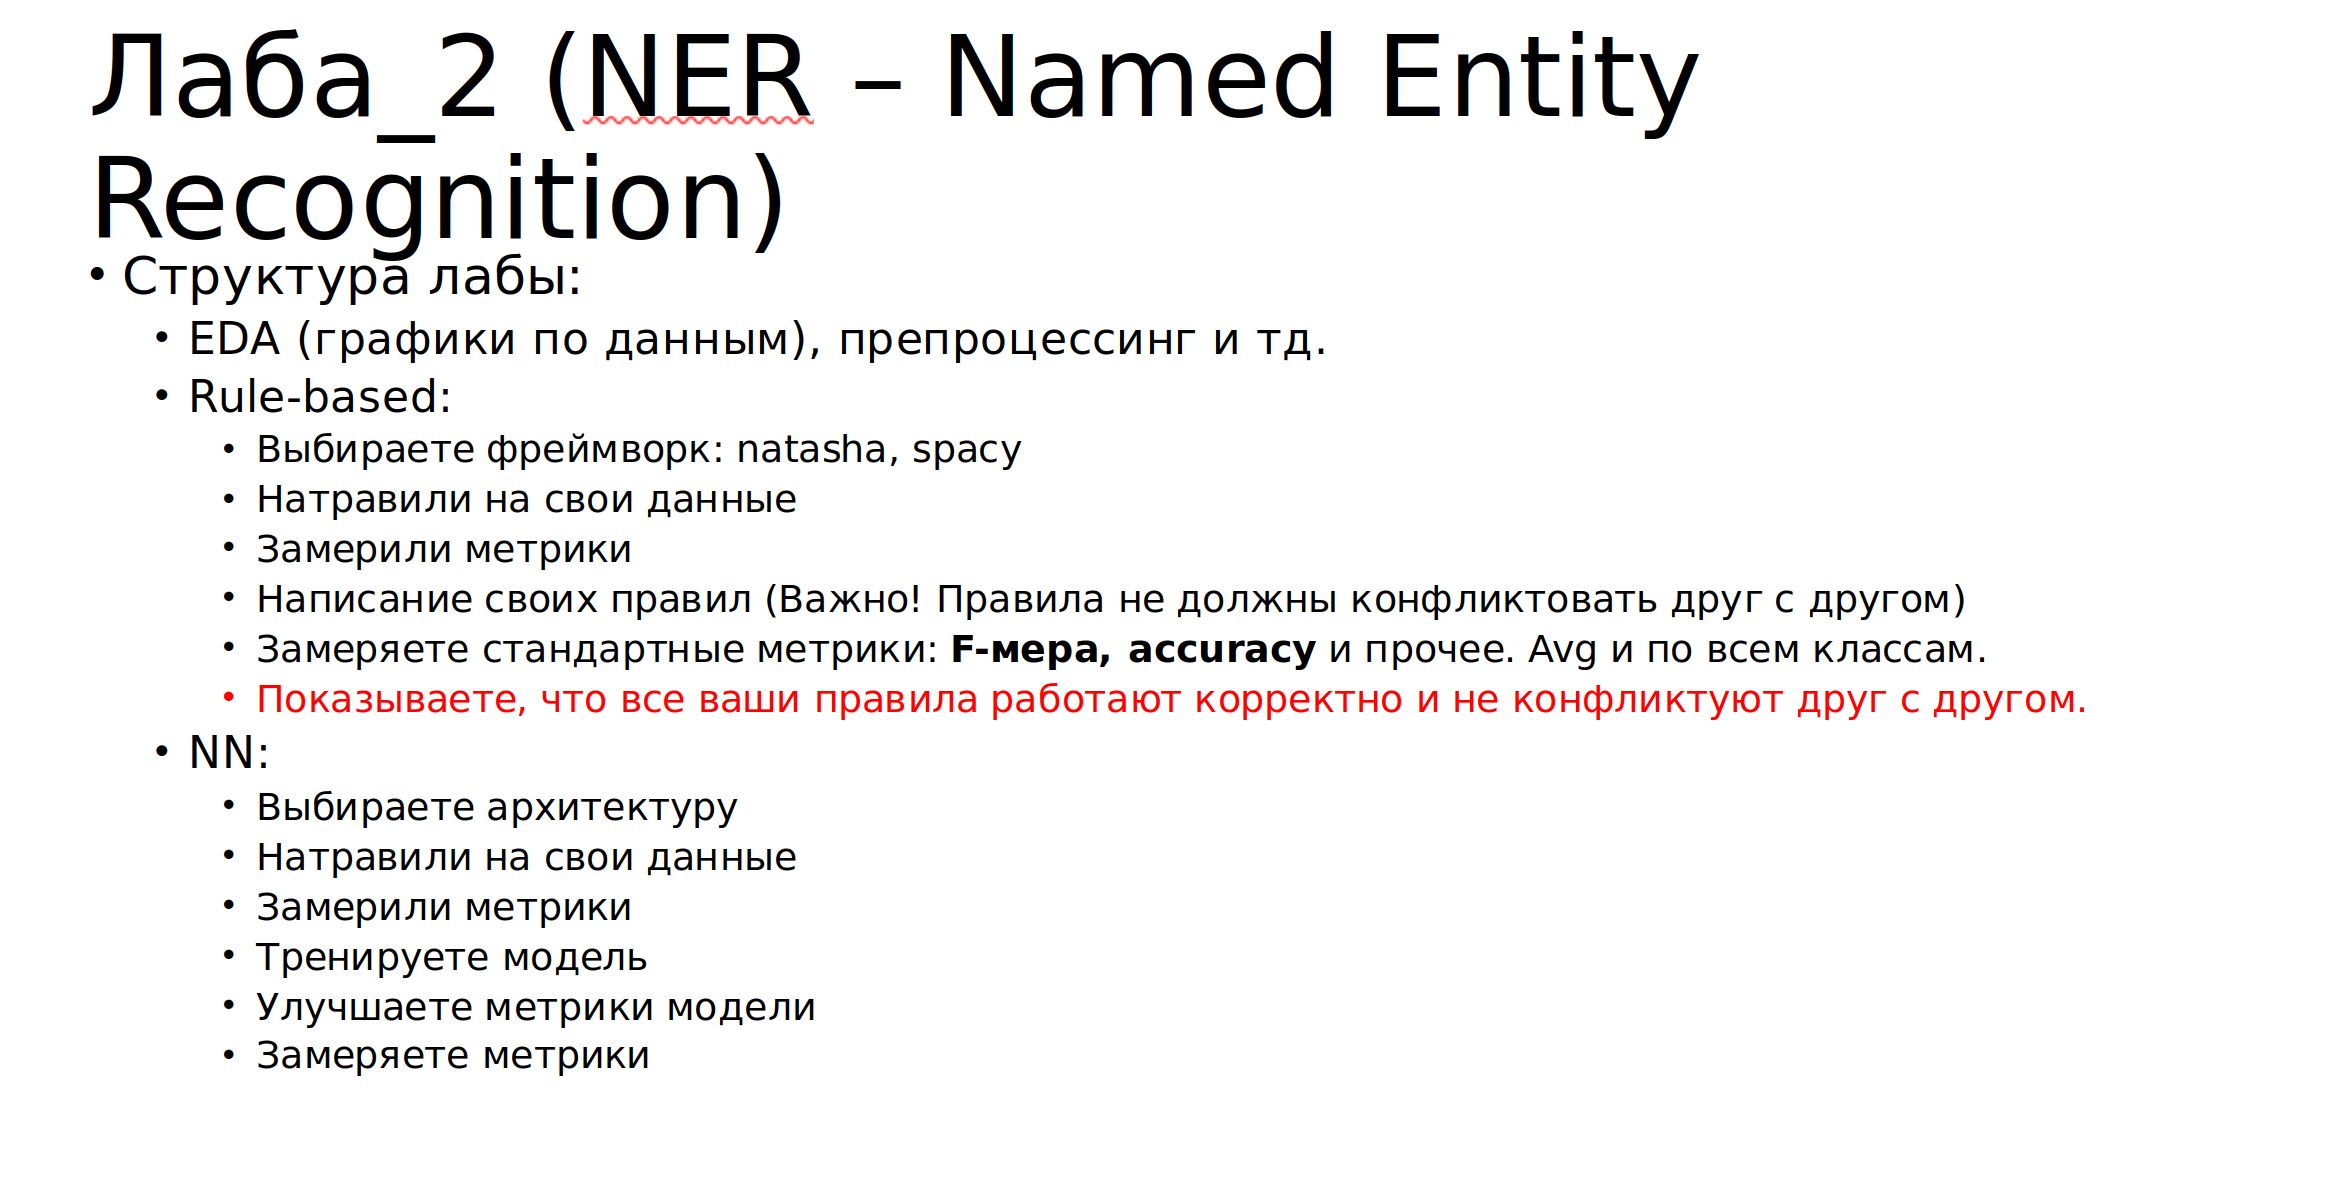

## Данные

[Ссылка на датасет](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data)

Выбранный датасет содержит около 140000 предложений, взятых из статей англоязычной википедии.

In [ ]:
import pandas as pd
import numpy as np

file = './data/wikiner.txt'
with open(file, 'r') as f:
    file = f.readlines()

data = []
data_dict = {}
for line in file:
    try:
        ind, word, label = line.split()
    except:
        continue
    if ind == '0':
        data.append(data_dict)
        data_dict = {'tokens': [word], 'labels': [label]}
    else:
        data_dict['tokens'].append(word)
        data_dict['labels'].append(label)


data = pd.DataFrame(data[1:])
data.head()

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=42)

train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)
print(f'Train size: {train_data.shape[0]}')
print(f'Test size: {test_data.shape[0]}')

train_data.to_csv('./data/train.csv', index=False)
test_data.to_csv('./data/test.csv', index=False)

Train size: 108255
Test size: 36086


In [ ]:
from ast import literal_eval
import pandas as pd

converter = {'tokens': literal_eval, 'labels': literal_eval}
train_data = pd.read_csv('train.csv', converters=converter)
test_data = pd.read_csv('test.csv', converters=converter)

test_data.drop('Unnamed: 0', axis=1, inplace=True)
train_data.drop('Unnamed: 0', axis=1, inplace=True)

В данных представлена разметка. Каждому токену присвоен лейбл: О если токен не является частью именованной сущности, В если с этого токена начинается подпоследовательность именованной сущности, I - если токен принадлежит подпоследовательности именованной сущности.

Дополнительно лейблы I и B классифицированы на следующие классы:

* PER - Человек
* ORG - Организация
* LOC - Место
* MISC - именованная сущность, не пренадлежащая какой-либо из вышеописанных категорий (событие, произведение искусства и т.д.)


Посмотрим на разметку глазами:

In [ ]:
import random

num_examples = 5
for document in range(num_examples):
  # beginning = random.randint(0, len(train_data.tokens[document]) - 16)
  beginning = 0
  ending = beginning + 20

  print(f'Document {document}, tokens from {beginning} to {ending}:')
  print(
      pd.DataFrame(
          {
              'tokens:': train_data.tokens[document][beginning:ending],
              'labels:': train_data.labels[document][beginning:ending]
          }
      )
      .transpose()
      .to_string(index=True, header=False),
      '\n'
  )


Document 0, tokens from 0 to 20:
tokens:  Agrippina    the  Younger  has  been  described  by  both  the  ancient  and  modern  sources  as  '  ruthless  ,  ambitious  ,  violent
labels:      B-PER  I-PER    I-PER    O     O          O   O     O    O        O    O       O        O   O  O         O  O          O  O        O 

Document 1, tokens from 0 to 20:
tokens:  Nature  defended  its  story  and  declined  to  retract  ,  stating  that  ,  as  it  was  comparing  Wikipedia  with  the  web
labels:  B-MISC         O    O      O    O         O   O        O  O        O     O  O   O   O    O          O     B-MISC     O    O    O 

Document 2, tokens from 0 to 20:
tokens:  The   Gaza  Strip  has  a  small  ,  poorly  developed  road  network  .
labels:    O  B-LOC  I-LOC    O  O      O  O       O          O     O        O  O 

Document 3, tokens from 0 to 20:
tokens:  Other  parts  of  the  society  's  land  were  acquired  by  the  American  Bridge  Company  to  expand  the  town  of  

Посмотрим на примеры категорий:

In [ ]:
labels = set([
    label.split('-')[-1]
    for annot in train_data.labels
    for label in annot
]) - {'O'}


def get_examples(label: str, num_examples: int):
  examples = []
  for document in range(0, train_data.shape[0]):
    if len(examples) >= num_examples:
      return examples
    try:
      beginning = train_data.labels[document].index(f'B-{label}')
    except ValueError:
      continue

    example = train_data.tokens[document][beginning].strip()
    for token_id in range(beginning + 1, len(train_data.tokens[document]) - 1):
      if train_data.labels[document][token_id] == f'I-{label}':
        example += ' ' + train_data.tokens[document][token_id].strip()
    examples.append(example)

  print(f'WARNING: could not find {num_examples} examples for label {label}, found {len(examples)} examples')
  return examples


label_examples = {}
for label in labels:
  label_examples[label] = get_examples(label=label, num_examples=10)

In [ ]:
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in label_examples.items()])).T

,0,1,2,3,4,5,6,7,8,9
LOC,Gaza Strip,Ambridge,Tibur Hills,Lake District National Park,Elstree,Ballarat Line railway station,Iraq,Greece,New York,Broadway River Bridge Hill Bronx Cortlandt Park
PER,Agrippina the Younger,Chopin,Charles II,Hadrian,Augustine,Louis Theroux,Ceolfrith,Paul VI,John Russell,Steiner
ORG,American Bridge Company,Liberal Party,News Chronicle,Houston,Tammany Hall,San Francisco State College,Hunter,Freeview,8th Air Force,Durham
MISC,Nature,Eastern Orthodox Church,Welsh,Keep the Aspidistra Flying,Republican,A Pattern Language,CH-46,Godzilla vs. Biollante,Veronica Mars,World War II Liberator


## EDA

### Какова длина предложений?

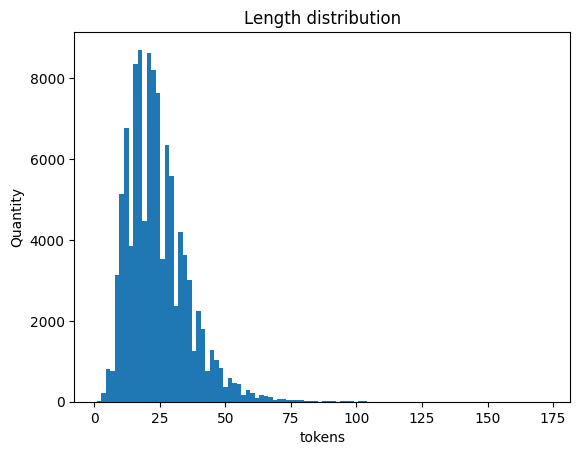

In [ ]:
train_data.tokens.apply(len).plot.hist(title='Length distribution', xlabel='tokens', ylabel='Quantity', bins=100);

### Как часто встречаются NE?

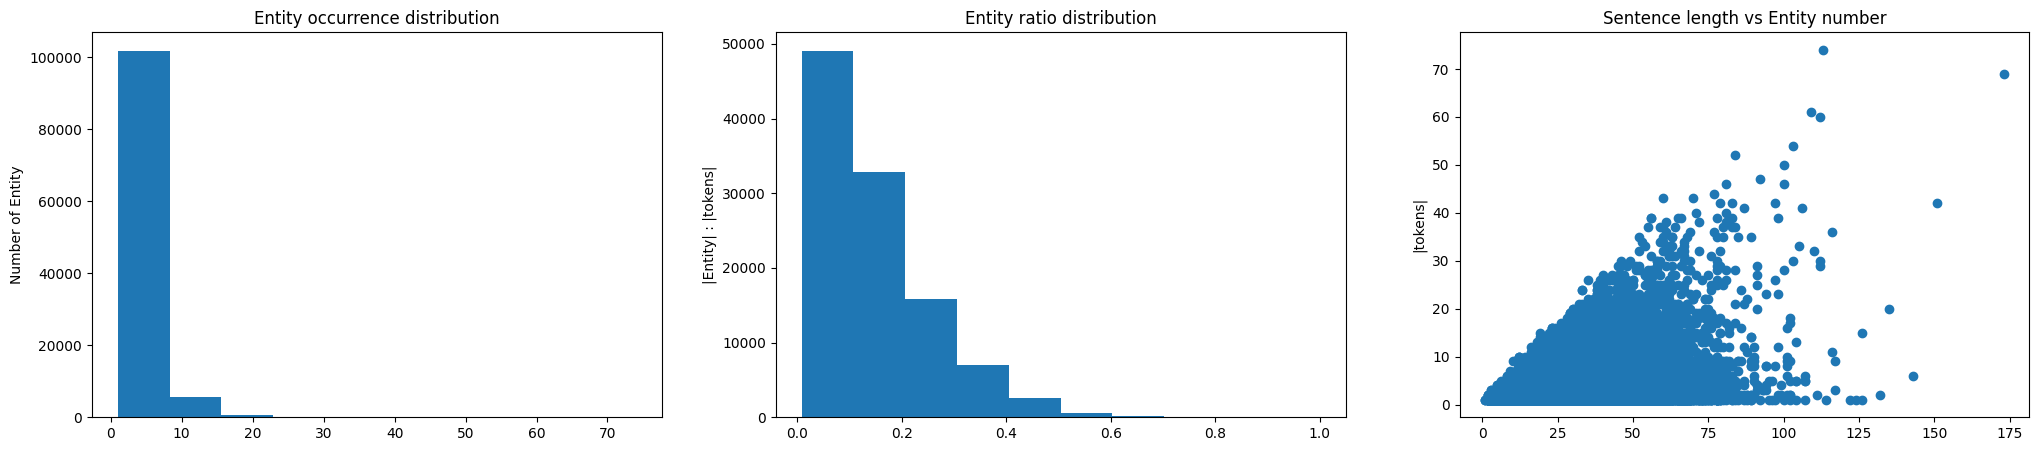

In [ ]:
from matplotlib import pyplot as plt

non_pii_count = train_data.labels.apply(lambda x: x.count('O'))
pii_count = train_data.labels.apply(len) - non_pii_count
pii_ratio = pii_count / train_data.labels.apply(len)


fig, axes = plt.subplots(1, 3, figsize=(25, 5))
axes[0].hist(pii_count)
axes[0].set_title('Entity occurrence distribution')
axes[0].set_ylabel('Number of Entity')

axes[1].hist(pii_ratio)
axes[1].set_title('Entity ratio distribution')
axes[1].set_ylabel('|Entity| : |tokens|')

axes[2].scatter(train_data.labels.apply(len), pii_count)
axes[2].set_title('Sentence length vs Entity number')
axes[2].set_ylabel('|Entity|')
axes[2].set_ylabel('|tokens|')

plt.show()

In [ ]:
print('Среднее количество сущностей в тексте:', pii_count.mean(), 'Максимальное количество: ', pii_count.max())

Среднее количество сущностей в тексте: 3.3754376241282156 Максимальное количество:  74


In [ ]:
print('Коэффициент корреляции длины и кол-ва NE:', np.corrcoef(pii_count, train_data.labels.apply(len))[0, 1])

Коэффициент корреляции длины и кол-ва NE: 0.38642485300249035


В целом, интересующие категории встречаются не очень часто: в среднем меньше пяти раз, при этом максимальное наблюдаемое количество -- 74. Они как правило составляют менее 10 процентов от общего текста.

Присутствует небольшая положительная корреляция между количеством сущностей и длиной предложения, что вполне логично.

### Распределение категорий

In [ ]:
labels_list = ['ORG', 'PER', 'LOC', 'MISC']

def plot_categ_distribution(data):
    labels_dict = dict(zip(labels_list, [0] * 4))
    def count_labels(tokens):
        for token in tokens:
            if token.startswith('B'):
                labels_dict[token.split('-')[-1]] += 1
    data['labels'].apply(count_labels)
    plt.bar(labels_dict.keys(), labels_dict.values())

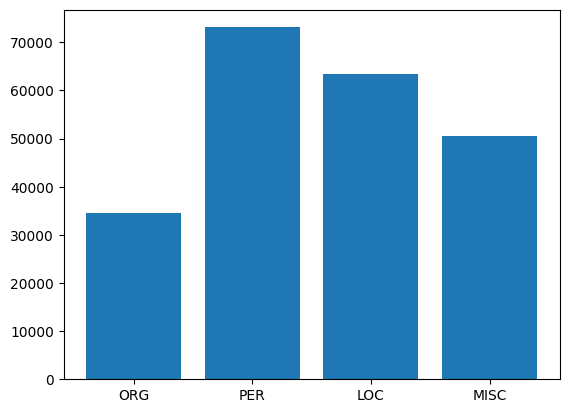

In [ ]:
plot_categ_distribution(train_data)

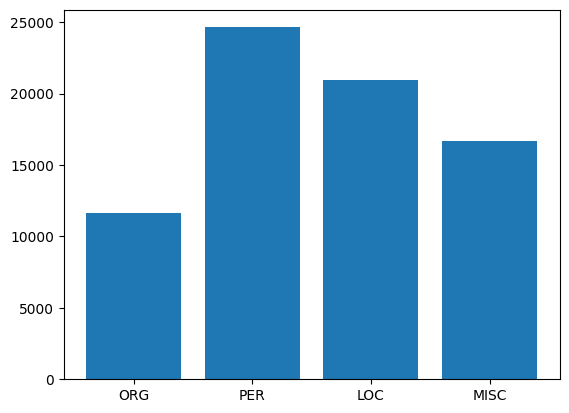

In [ ]:
plot_categ_distribution(test_data)

Как можно видеть, меньше всего в датасете представлено организаций, больше всего - персон. Распределение в тренировочной и тестовой выборке  совпадают.  
Остальные именованные сущности (MISC) тоже представлены меньше, по сравнению с остальными. Если учесть что они сами являются примерами из различных категорий, с их идентифицированием могут возникнуть проблемы, так как они могут быть слаюо представлены.

Дополнительно рассмотрим, какие категории встречаются чаще в одном и том же предложении.

In [ ]:
categories = ['PER', 'LOC', 'MISC', 'ORG']


def plot_cooccurrence(data: pd.DataFrame) -> None:
    co_occurrence = pd.DataFrame(0, index=categories, columns=categories)

    for _, row in tqdm(data.iterrows()):
        sentence_labels = set(label.split('-')[-1] for label in row['labels'] if label != 'O')
        for cat1 in sentence_labels:
            for cat2 in sentence_labels:
                if cat1 == cat2:
                    continue
                if cat1 in categories and cat2 in categories:
                    co_occurrence.loc[cat1, cat2] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(co_occurrence, annot=True, cmap="YlGnBu", fmt="d", square=True,
                cbar_kws={'label': 'Number of Co-occurrences'}, linewidths=0.5)
    plt.title("NER Category Co-occurrence Heatmap", fontsize=16)
    plt.xlabel("NER Category", fontsize=14)
    plt.ylabel("NER Category", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_cooccurrence(train_data)

NameError: name 'tqdm' is not defined

In [ ]:
plot_cooccurrence(test_data)

### Частеречная характеристика категорий

In [ ]:
from collections import defaultdict
import seaborn as sns

def extract_pos_distribution(data: pd.DataFrame,
                             preds: list[spacy.tokens.Doc]) -> defaultdict:
  pos_distribution = defaultdict(lambda: defaultdict(int))
  pos_tags = [[token.pos_ for token in document] for document in preds]
  for idx, row in data.iterrows():
      for token, label, pos in zip(row['tokens'], row['labels'], pos_tags[idx]):
          if label != 'O':
              entity_type = label.split('-')[-1]
              pos_distribution[entity_type][pos] += 1

  return pos_distribution


def visualize_pos_distribution(pos_distribution: defaultdict) -> None:
  pos_df = pd.DataFrame(pos_distribution).fillna(0).T.astype(int)
  plt.figure(figsize=(14, 10))
  sns.heatmap(pos_df, annot=True, fmt="d", cmap="Blues",
              cbar_kws={'label': 'Frequency'}, linewidths=0.5,
              annot_kws={"size": 10})

  plt.title("PoS Distribution for each NER Category", fontsize=16)
  plt.ylabel("NER Categories", fontsize=14)
  plt.xlabel("POS Tags", fontsize=14)
  plt.xticks(rotation=45, fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

In [ ]:
train_pos_distr = extract_pos_distribution(train_data, train_preds)
visualize_pos_distribution(train_pos_distr)

In [ ]:
test_pos_distr = extract_pos_distribution(test_data, test_preds)
visualize_pos_distribution(test_pos_distr)

NameError: name 'extract_pos_distribution' is not defined

## Spacy и rule-based подход

### Оценка стартового качества

Модель SpaCy `en_core_web_sm` поддерживает классификацию NER на следующие категории:

* CARDINAL - Numerals that do not fall under another type.
* DATE -  Absolute or relative dates or periods.
* EVENT - Named hurricanes, battles, wars, sports events, etc.
* FAC - Buildings, airports, highways, bridges, etc.
* GPE - Countries, cities, states.
* LANGUAGE - Any named language.
* LAW - Named documents made into laws.
* LOC - Non-GPE locations, mountain ranges, bodies of water.
* MONEY - Monetary values, including unit.
* NORP - Nationalities or religious or political groups.
* ORDINAL - "first", "second", etc.
* ORG - Companies, agencies, institutions, etc.
* PERCENT - Percentage, including "%".
* PERSON - People, including fictional.
* PRODUCT - Objects, vehicles, foods, etc. (Not services.)
* QUANTITY - Measurements, as of weight or distance.
* TIME - Times smaller than a day.
* WORK_OF_ART - Titles of books, songs, etc.

In [ ]:
from ast import literal_eval

converter = {'tokens': literal_eval, 'labels': literal_eval}

train_data = pd.read_csv('./data/train.csv', converters=converter)
test_data = pd.read_csv('./data/test.csv', converters=converter)

In [ ]:
! pip install evaluate seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import spacy
from spacy.tokens import Doc, DocBin
import evaluate
from tqdm import tqdm
tqdm.pandas()

metric = evaluate.load("seqeval")
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
labels_set = list(labels_list)
global_metrics = ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']

labels_correspondance = {
    'ORG': 'ORG',
    'PERSON': 'PER',
    'LOC': 'LOC',
    'GPE': 'LOC',
    'FAC': 'LOC',
    'PRODUCT': 'MISC',
    'EVENT': 'MISC',
    'WORK_OF_ART': 'MISC',
    'LANGUAGE': 'O',
    'DATE': 'O',
    'TIME': 'O',
    'PERCENT': 'O',
    'MONEY': 'O',
    'QUANTITY': 'O',
    'ORDINAL': 'O',
    'CARDINAL': 'O'
}

def convert_tag(tag):
  if tag == 'O':
    return tag
  bio, category = tag.split('-')
  new_category = labels_correspondance.get(category, 'O')
  if new_category == 'O':
    return new_category
  return f'{bio}-{new_category}'

def compute_spacy_metrics(docs, labels, metric):
    predictions = map(lambda row: [e.ent_iob_ + '-' + e.ent_type_ if e.ent_iob_ != 'O' else 'O' for e in row], docs)
    # predictions = map(lambda row: [e[0] + '-MISC' if (e != 'O' and e.split('-')[-1] not in labels_set) else e for e in row], predictions)
    predictions = list(map(lambda row: [convert_tag(e) for e in row], predictions))
    metrics = metric.compute(predictions=list(predictions), references=labels)
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    return metrics_class, metrics_global

def make_docs(data, nlp, save_path):
    predictions = data['tokens'].progress_apply(lambda row: nlp(Doc(nlp.vocab, row)))
    doc_bin = DocBin(store_user_data=True)
    for doc in predictions:
        doc_bin.add(doc)
    bytes_data = doc_bin.to_bytes()
    with open(save_path, 'wb') as fout:
        fout.write(bytes_data)
    return bytes_data

def load_docs(save_path):
    with open(save_path, 'rb') as fout:
        bytes_data = fout.read()
    doc_bin = DocBin().from_bytes(bytes_data)
    docs = list(doc_bin.get_docs(nlp.vocab))
    return docs

def visualize_metrics(category_metrics, overall_metrics):
    categories = list(category_metrics.keys())
    precisions = [category_metrics[cat]['precision'] for cat in categories]
    recalls = [category_metrics[cat]['recall'] for cat in categories]
    f1_scores = [category_metrics[cat]['f1'] for cat in categories]

    bar_width = 0.25
    r1 = np.arange(len(categories))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.figure(figsize=(12, 6))
    plt.bar(r1, precisions, color='skyblue', width=bar_width, edgecolor='grey', label='Precision')
    plt.bar(r2, recalls, color='lightgreen', width=bar_width, edgecolor='grey', label='Recall')
    plt.bar(r3, f1_scores, color='salmon', width=bar_width, edgecolor='grey', label='F1 Score')

    plt.axhline(overall_metrics['overall_precision'], color='blue', linewidth=1.5, linestyle='--', label='Overall Precision')
    plt.axhline(overall_metrics['overall_recall'], color='green', linewidth=1.5, linestyle='--', label='Overall Recall')
    plt.axhline(overall_metrics['overall_f1'], color='red', linewidth=1.5, linestyle='--', label='Overall F1 Score')

    plt.xlabel('Categories', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.title('Category-Specific and Overall Metrics', fontsize=16)
    plt.xticks([r + bar_width for r in range(len(categories))], categories)
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
#make_docs(test_data, nlp, 'test_doc.bin')
#make_docs(train_data, nlp, 'train_doc.bin')

In [ ]:
test_preds = load_docs('test_doc.bin')
train_preds = load_docs('train_doc.bin')

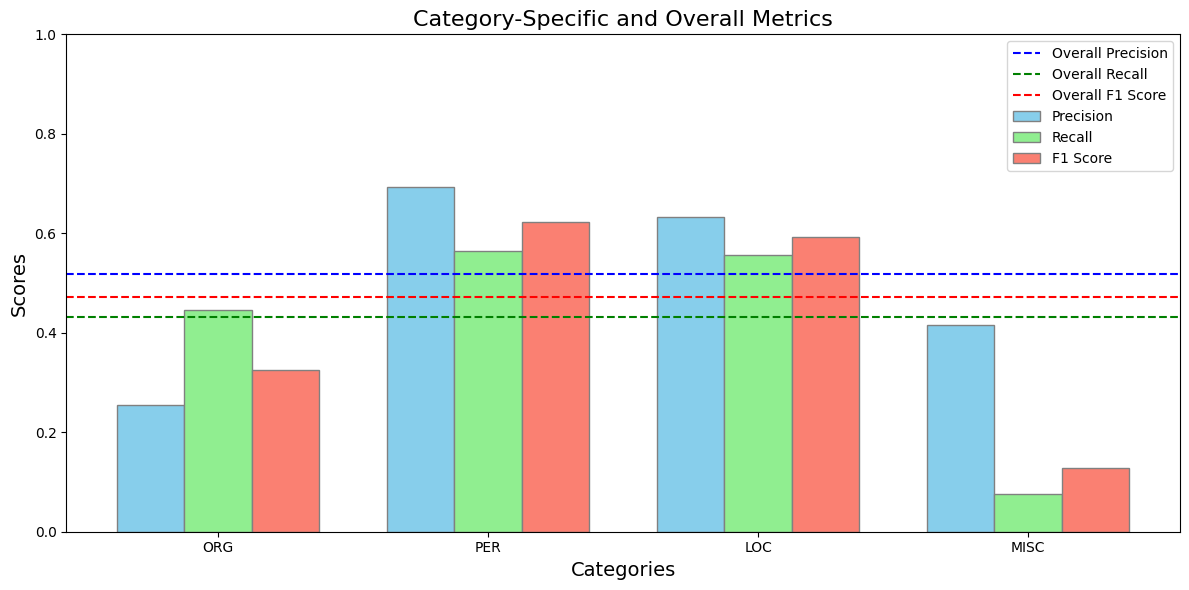

In [ ]:
test_metrics = compute_spacy_metrics(test_preds, test_data['labels'], metric)
visualize_metrics(*test_metrics)

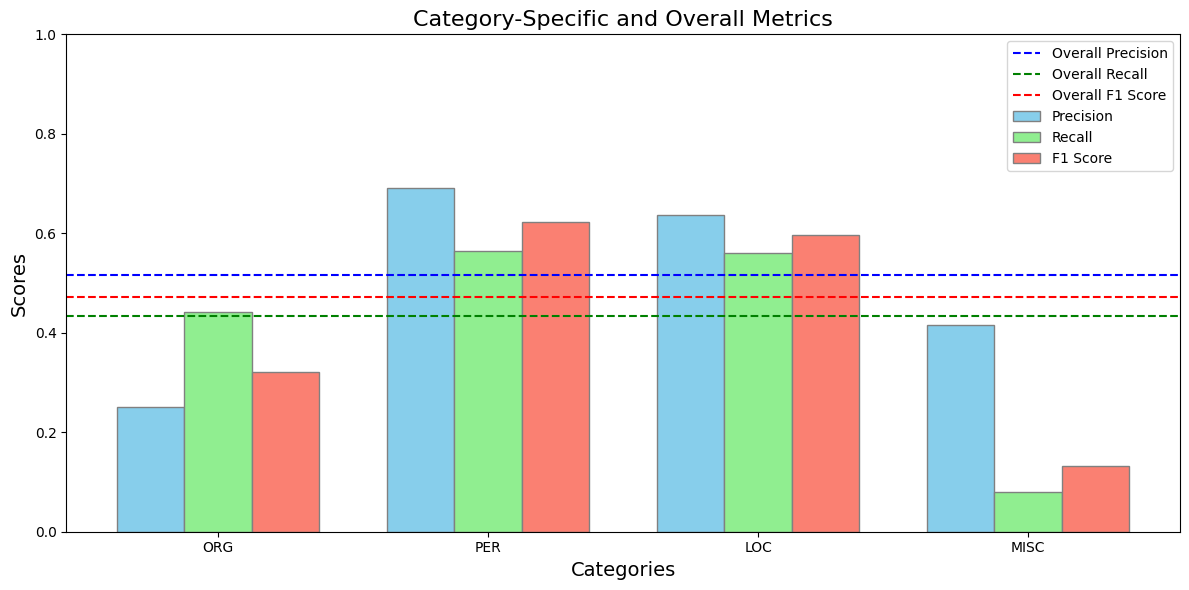

In [ ]:
train_metrics = compute_spacy_metrics(train_preds, train_data['labels'], metric)
visualize_metrics(*train_metrics)

### Error analysis

In [ ]:
def extract_predictions(data: pd.DataFrame, preds: list[spacy.tokens.Doc]) -> pd.DataFrame:
    data['raw_predictions'] = list(map(lambda row: [e.ent_iob_ + '-' + e.ent_type_ if e.ent_iob_ != 'O' else 'O' for e in row], preds))
    data['predictions'] = list(map(lambda row: [convert_tag(e) for e in row], data['raw_predictions']))
    return data

def error_example(data: pd.DataFrame, category: str, n_examples: int = 5):
    true = data.labels.apply(lambda x: f'B-{category}' in x)
    positive = data.predictions.apply(lambda x: f'B-{category}' in x)

    for title, examples in zip(
        [f'Unrecognized {category} entities',
         f'Falsely recognized  {category} entities'],
        [data[true & ~positive], data[~true & positive]]
    ):
        print(f'\033[1m{title}\033[0;0m:\n')
        examples = examples[:n_examples]
        for example in range(min(n_examples, len(examples))):
              print(
                pd.DataFrame(
                    {
                        'tokens:': examples.tokens.iloc[example],
                        'true  :': examples.labels.iloc[example],
                        'pred  :': examples.predictions.iloc[example],
                        'raw   :': examples.raw_predictions.iloc[example]

                    }
                )
                .transpose()
                .to_string(index=True, header=False),
                '\n'
            )


In [ ]:
train_data = extract_predictions(train_data, train_preds)
test_data = extract_predictions(test_data, test_preds)

for category in labels_list:
  error_example(train_data, category, n_examples=2)

Unrecognized ORG entities:

tokens:  Houston  lost          10  --           3  but  it  was  a  glimpse  of  what  was  to  come  in     the    next     few  seasons  .
true  :    B-ORG     O           O   O           O    O   O    O  O        O   O     O    O   O     O   O       O       O       O        O  O
pred  :    B-LOC     O           O   O           O    O   O    O  O        O   O     O    O   O     O   O       O       O       O        O  O
raw   :    B-GPE     O  B-CARDINAL   O  B-CARDINAL    O   O    O  O        O   O     O    O   O     O   O  B-DATE  I-DATE  I-DATE   I-DATE  O 

tokens:  The  group  was  inspired  by  student-initiated  experimental  schools  ,  especially    San  Francisco  State  College  ,  and  sought  ways  to  improve  education  for  students  at     Brown  .
true  :    O      O    O         O   O                  O             O        O  O           O  B-ORG      I-ORG  I-ORG    I-ORG  O    O       O     O   O        O          O    O         O   O

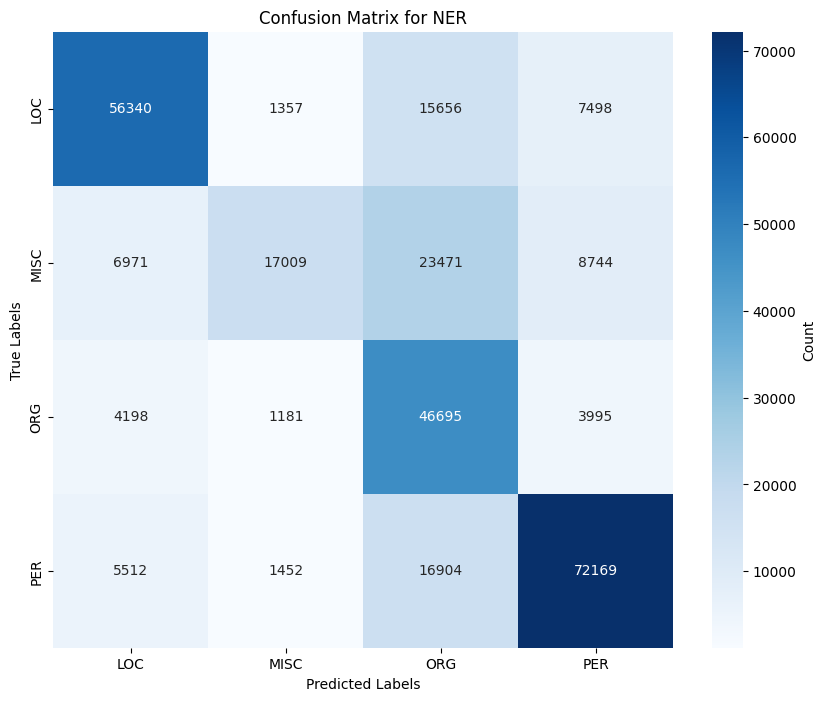

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def draw_confusion_matrix(predictions, labels):
    flatten_tag = lambda tag: tag if tag == 'O' else tag.split('-')[-1]
    flattened_true = [flatten_tag(tag) for sentence in labels for tag in sentence]
    flattened_pred = [flatten_tag(tag) for sentence in predictions for tag in sentence]
    
    labels = sorted(set(flattened_true) | set(flattened_pred))
    labels.remove('O')
    conf_matrix = confusion_matrix(flattened_true, flattened_pred, labels=labels)
    
    conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix for NER')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

draw_confusion_matrix(train_data.predictions, train_data.labels)

Многие ошибки завязаны на омонимии:  Brown, Hunter, Houston могут выступать как именами, так и местами/организациями.

Также есть отличия в том, включаются артикли или нет.
Так, сочетания the  United  Kingdom, the  Harlem  River, the  Bronx имеют аннотацию именованной сущности в датасете, тогда как модель помечает токен the как О. Напротив, обратная проблема наблюдается с сочетанием the  Sabine  Hills.

Также ряд ошибок связан с тем, что многие организации содержат в себе географические названия: San  Francisco  State  College. Модель помечает это как LOC, тогда как ожидается ORG.

Попробуем точечно исправить эти ошибки.

### My homework my rules

In [ ]:
def get_id_by_string(data: pd.DataFrame, string: str):
    return data[data['tokens'].apply(lambda x: string in x)].index.tolist()


def display_text_prettily(data: pd.DataFrame, instances: int | None = None):
    indices = list(range(len(data))) if instances is None else random.sample(range(len(data)), instances)
    for index in indices:
      print(
        pd.DataFrame(
            {
                'tokens:': data.tokens.iloc[index],
                'true  :': data.labels.iloc[index],
                'old   :': data.predictions.iloc[index],
                'new   :': data.new_predictions.iloc[index]
            }
        )
        .transpose()
        .to_string(index=True, header=False),
        '\n'
    )


def calculate_metrics(predictions: list[str], labels: list[str], metric):
    metrics = metric.compute(predictions=list(predictions), references=labels)
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    return metrics_class, metrics_global


In [ ]:
error_patterns = [
    'Brown', 'Hunter', 'Houston', 'Nauvoo',
    'Britannica', 'Cascades', 'Centauri', 'Isles',
    'Kingdom', 'Harlem', 'Bronx', 'College'

]
error_samples = []
for error_pattern in error_patterns:
  error_samples.extend(get_id_by_string(train_data, error_pattern))
train_data_error_subset = train_data.loc[error_samples]
print(f'Error focused subset lengths: {train_data_error_subset.shape}')

Error focused subset lengths: (1383, 4)


In [ ]:
patterns = [
    {"label": "LOC", "pattern": "Alpha Centauri"},
    {"label": "LOC", "pattern": "Nauvoo"},
    {"label": "LOC", "pattern": "Houston"},
    {"label": "LOC", "pattern": "Mauritius"},
    {"label": "LOC", "pattern": "Columbia"},
    {"label": "LOC", "pattern": "Dartmouth"},
    {"label": "LOC", "pattern": "Croatia"},


    {"label": "LOC", "pattern": "Cascades Rapids"},
    {"label": "LOC", "pattern": "British Isles"},
    {"label": "LOC", "pattern": "Diego  Garcia"},

    {"label": "LOC", "pattern": "the  United  Kingdom"},
    {"label": "LOC", "pattern": "the  Harlem  River"},
    {"label": "LOC", "pattern": "The  Bronx"},

    {"label": "ORG", "pattern": "Hush Hip Hop Tours"},
    {"label": "ORG", "pattern": "The  Hunter  College"},
    {"label": "ORG", "pattern": "San  Francisco  State  College"},
    {"label": "ORG", "pattern": "Houston Post"},

    {"label": "ORG", "pattern": "Brown"},
    {"label": "ORG", "pattern": "Hunter"},
    {"label": "ORG", "pattern": "Houston"},

    {"label": "PER", "pattern": "Auchinleck"},
    {"label": "PER", "pattern": "Clarence  Brown"},

    {"label": "MISC", "pattern": "Encyclopaedia  Britannica"},
    {"label": "MISC", "pattern": "Encyclop?dia  Britannica"},
    {"label": "MISC", "pattern": "Britannica"},
    {"label": "MISC", "pattern": "Wikipedia"},
    {"label": "MISC", "pattern": "Napoleonic wars"},
    {"label": "MISC", "pattern": "battle of Waterloo"},
    {"label": "MISC", "pattern": "Heart of Oak"},

]

nlp = spacy.load("en_core_web_sm")
old_docs = train_data_error_subset['tokens'].progress_apply(lambda row: nlp(Doc(nlp.vocab, row)))

ruler = nlp.add_pipe("entity_ruler", before='ner')
ruler.add_patterns(patterns)

100%|██████████| 1383/1383 [00:18<00:00, 76.30it/s]


In [ ]:
old_docs = train_data_error_subset['tokens'].progress_apply(lambda row: nlp(Doc(nlp.vocab, row)))
new_predictions = list(map(lambda row: [e.ent_iob_ + '-' + e.ent_type_ if e.ent_iob_ != 'O' else 'O' for e in row], old_docs))
train_data_error_subset['new_predictions'] = list(map(lambda row: [convert_tag(e) for e in row], new_predictions))

100%|██████████| 1383/1383 [00:17<00:00, 78.01it/s]


In [ ]:
calculate_metrics(train_data_error_subset['predictions'].tolist(),
                  train_data_error_subset['labels'].tolist(),
                  metric)

({'ORG': {'precision': 0.4714738510301109,
   'recall': 0.49916107382550334,
   'f1': 0.484922575387123,
   'number': 1192},
  'PER': {'precision': 0.5749414519906323,
   'recall': 0.7115942028985507,
   'f1': 0.6360103626943004,
   'number': 690},
  'LOC': {'precision': 0.5477629987908101,
   'recall': 0.5150653780557135,
   'f1': 0.5309112217990039,
   'number': 1759},
  'MISC': {'precision': 0.48484848484848486,
   'recall': 0.10084033613445378,
   'f1': 0.16695652173913045,
   'number': 476}},
 {'overall_precision': 0.5272680279141897,
  'overall_recall': 0.4955064367257712,
  'overall_f1': 0.510894064613073,
  'overall_accuracy': 0.8876212955677943})

In [ ]:
calculate_metrics(train_data_error_subset['new_predictions'].tolist(),
                  train_data_error_subset['labels'].tolist(),
                  metric)

({'ORG': {'precision': 0.4149797570850202,
   'recall': 0.5159395973154363,
   'f1': 0.4599850411368736,
   'number': 1192},
  'PER': {'precision': 0.6018867924528302,
   'recall': 0.4623188405797101,
   'f1': 0.5229508196721311,
   'number': 690},
  'LOC': {'precision': 0.546037296037296,
   'recall': 0.5326890278567368,
   'f1': 0.5392805755395683,
   'number': 1759},
  'MISC': {'precision': 0.46534653465346537,
   'recall': 0.09873949579831932,
   'f1': 0.1629116117850953,
   'number': 476}},
 {'overall_precision': 0.5009140767824497,
  'overall_recall': 0.4658732086470731,
  'overall_f1': 0.4827586206896552,
  'overall_accuracy': 0.8845003933910307})

In [ ]:
display_text_prettily(train_data_error_subset, instances=10)

tokens:  He  attended    the  Slade  School     of    Art  in  order  to  become  an  illustrator  and  also  took  literature  classes  at  University  College  London  but  did  not  complete  a  degree  at  either  .
true  :   O         O      O  B-ORG   I-ORG  I-ORG  I-ORG   O      O   O       O   O            O    O     O     O           O        O   O       B-ORG    I-ORG   I-ORG    O    O    O         O  O       O   O       O  O
old   :   O         O  B-ORG  I-ORG   I-ORG  I-ORG  I-ORG   O      O   O       O   O            O    O     O     O           O        O   O       B-ORG    I-ORG   I-ORG    O    O    O         O  O       O   O       O  O
new   :   O         O  B-ORG  I-ORG   I-ORG  I-ORG  I-ORG   O      O   O       O   O            O    O     O     O           O        O   O       B-ORG    I-ORG   I-ORG    O    O    O         O  O       O   O       O  O 

tokens:    The  United  Kingdom     's  flag  carrier  during  this  period  was  Imperial  Airways  ,  which  became 

## Neural Networks

In [ ]:
label_2_id = {'O' :0, 'B-ORG': 1, 'I-ORG': 2, 'B-PER': 3, 'I-PER': 4,
              'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [ ]:
from src.data_utils import create_dataset, DataCollator, NERDataset
from src.model_utils import create_model
from src.training_utils import Trainer

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from functools import partial
from sklearn.metrics import f1_score


def plot_train_metrics(losses, metrics):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].plot(losses)
    axes[1].plot(metrics)
    
    axes[0].set_title('Train loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    
    axes[1].set_title('Val F1')
    axes[1].set_ylabel('F1')
    axes[1].set_xlabel('Epoch')


def compute_model_metrics(model_preds, targets):
    metrics = metric.compute(predictions=model_preds, references=test_data['labels'])
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    return metrics_class, metrics_global

Попробуем зафайнтьюнить претрененый на английском языке Bert на нашу задачу. Используем distilbert/distilbert-base-cased, поскольку в такой модели важно использованы в написании заглавные буквы, или нет. Это нужно нам, поскольку большинство именованных сущностей начинается с заглавных букв.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-cased')
model = create_model('distilbert/distilbert-base-cased', label_2_id)

train_data_processed = create_dataset(train_data, './data/train_tokenized.csv', max_len=model.config.max_position_embeddings,
                               tokenizer=tokenizer, labels_mapping=label_2_id)

val_data_processed = create_dataset(test_data, './data/test_tokenized.csv', max_len=model.config.max_position_embeddings,
                               tokenizer=tokenizer, labels_mapping=label_2_id)

train_dataset = NERDataset(train_data_processed)
val_dataset = NERDataset(val_data_processed)

In [ ]:
collator = DataCollator(token_pad_id=tokenizer.pad_token_id)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collator, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collator, drop_last=False)

In [ ]:
lr = 2e-5
weight_decay = 0.05
epochs = 3
warmup_steps = 0

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, epochs * len(train_dataloader))

trainer = Trainer(model, optimizer, train_dataloader, val_dataloader,
                  partial(f1_score, average=None, labels=list(range(1, 9))), device=device, scheduler=scheduler)

losses, metrics = trainer.train(epochs, './bert_base_test')
plot_train_metrics(losses, metrics)

In [ ]:
from src.validation_utils import inference


best_model = torch.load('./bert_base_cased_best_result/best_model.pth').to(device).eval()
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collator, drop_last=False)
model_preds = inference(best_model, val_dataloader, val_data_processed['word_inds'], {v: k for k, v in label_2_id.items()}, device=device)

calculate_metrics(model_preds, test_data['labels'], metric)

In [ ]:
draw_confusion_matrix(model_preds, test_data['labels'].tolist())